In [24]:
BATCH_SIZE = 80
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 10
MAX_TRAIN_EPOCHS = 90
AUGMENT_BRIGHTNESS = False

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = 'F:\\Downloads\\all\\'
train_image_dir = os.path.join(ship_dir, 'train1')
test_image_dir = os.path.join(ship_dir, 'data_test_3_task')

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks = rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [2]:
masks = pd.read_csv(os.path.join('F:\\Downloads\\all\\',
                                 'CSV_for_train1.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

31642 masks in 15803 images
0 empty images in 15803 total images


,Unnamed: 0,ImageId,EncodedPixels
0,0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,1,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
2,2,0005d01c8.jpg,365871 1 366638 3 367405 6 368173 7 368940 9 3...
3,3,00113a75c.jpg,401790 1 402557 3 403325 5 404092 7 404859 9 4...
4,4,00113a75c.jpg,110888 2 111654 4 112420 7 113186 9 113953 11 ...


## Проверка encode/decode

Check Decoding->Encoding RLE_0: 7 -> RLE_1: 1
0 error


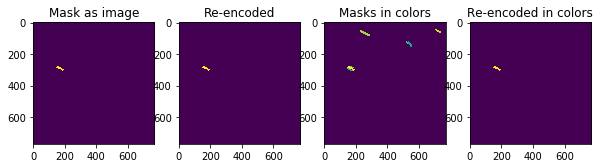

In [3]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00113a75c.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

## Разделим датасет на валидацию и тренировку 

Wall time: 1.98 s


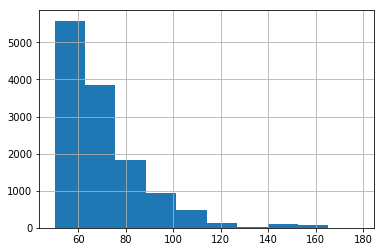

In [5]:
%%time
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# проверим размер изображения, чтобы выявить битые или плохого качества 
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id:
                                                               os.stat(os.path.join(train_image_dir,
                                                                                   c_img_id)).st_size/1024)
# отобразим в датасете только те изображени, чей размер больше 50Кб
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50]
unique_img_ids['file_size_kb'].hist()
unique_img_ids.sample(7)

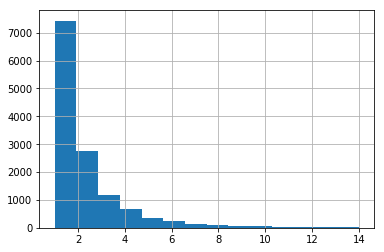

In [6]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

## Создадим сбалансированные группы по кораблям
Создадим датасет для обучения

In [7]:
unique_img_ids.head()

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
0,000155de5.jpg,1,1.0,[1.0],79.381836
2,00113a75c.jpg,7,1.0,[1.0],65.021484
4,0019fc4d8.jpg,1,1.0,[1.0],99.376953
6,001e418bc.jpg,1,1.0,[1.0],60.997070
7,0027854cc.jpg,1,1.0,[1.0],67.098633


4712 ships masks
Wall time: 37.9 ms


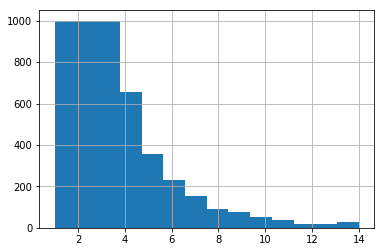

In [8]:
%%time
SAMPLES_PER_GROUP = 1000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: 
                                                         x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max())
print(balanced_train_df.shape[0], 'ships masks')
balanced_train_df = balanced_train_df.rename(columns={'ships':'count_ships'})
balanced_train_df.head(10)

In [9]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['count_ships'])

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.head(5)

14106 training masks
3522 validation masks


,Unnamed: 0,ImageId,EncodedPixels,ships,count_ships,has_ship,has_ship_vec,file_size_kb
0,12,001aee007.jpg,496304 1 497071 3 497838 5 498605 7 499372 9 5...,1,4,1.0,[1.0],90.428711
1,13,001aee007.jpg,414563 1 415330 3 416097 5 416864 7 417631 9 4...,1,4,1.0,[1.0],90.428711
2,14,001aee007.jpg,207463 1 208230 3 208997 5 209764 7 210531 9 2...,1,4,1.0,[1.0],90.428711
3,15,001aee007.jpg,241920 1 242687 2 243454 3 244221 4 244988 5 2...,1,4,1.0,[1.0],90.428711
4,20,002fdcf51.jpg,373563 2 374331 4 375098 7 375866 9 376633 12 ...,1,2,1.0,[1.0],137.112305


## Создаем генератор изображений

In [10]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_masks = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            # dawnsampling
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
                
            out_rgb += [c_img]
            out_masks += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_masks, 0)
                out_rgb = []
                out_masks = []

In [11]:
%%time
train_generator = make_image_gen(train_df)
train_x, train_y = next(train_generator)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1
Wall time: 1.41 s


C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is depr

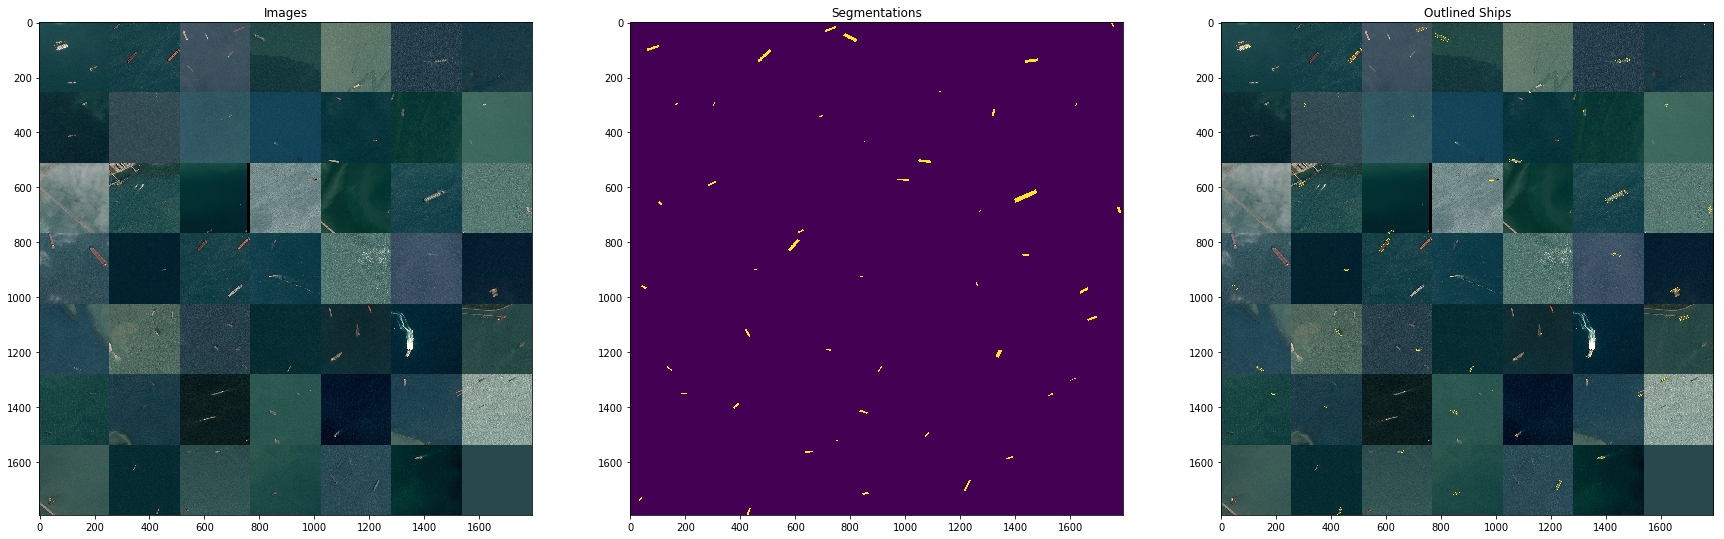

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

## Создадим датасет для валидации

In [13]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
Wall time: 16 s


In [14]:
from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

Using TensorFlow backend.


x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is depr

Text(0.5, 1.0, 'ships')

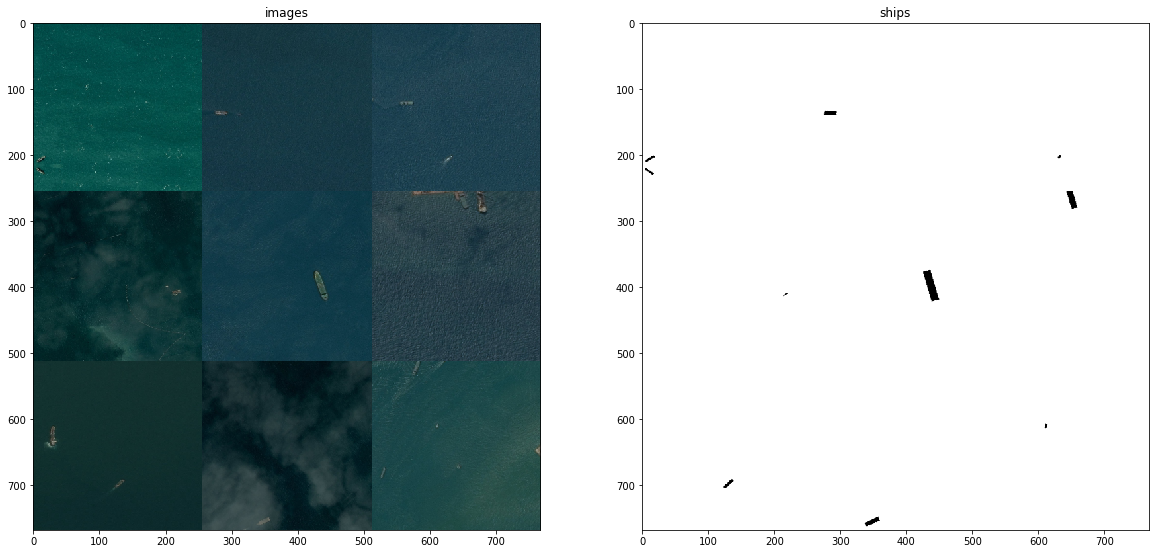

In [15]:
cur_gen = create_aug_gen(train_generator)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [16]:
# сборщик мусора
gc.collect()

0

## Собираем модель для обучения
Соберем архитектуру U-Net

In [27]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 256, 256, 3)  0           average_pooling2d_3[0][0]        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 3)  12          gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
conv2d_20 

In [28]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## метрика пересечения масок
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [29]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, 
                      patience=5)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [30]:
import tensorflow as tf
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.98
config.gpu_options.allocator_type="BFC"
config.log_device_placement=True
sess=tf.Session(config=config)

def fit():
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break

Epoch 1/90
10/10 [==============================] - 17s 2s/step - loss: -0.0038 - binary_accuracy: 0.0169 - val_loss: -0.0049 - val_binary_accuracy: 0.4945

Epoch 00001: val_loss improved from inf to -0.00489, saving model to seg_model_weights.best.hdf5
Epoch 2/90
10/10 [==============================] - 12s 1s/step - loss: -0.0042 - binary_accuracy: 0.4922 - val_loss: -0.0055 - val_binary_accuracy: 0.6481

Epoch 00002: val_loss improved from -0.00489 to -0.00545, saving model to seg_model_weights.best.hdf5
Epoch 3/90
10/10 [==============================] - 14s 1s/step - loss: -0.0209 - binary_accuracy: 0.9265 - val_loss: -0.0643 - val_binary_accuracy: 0.9571

Epoch 00003: val_loss improved from -0.00545 to -0.06433, saving model to seg_model_weights.best.hdf5
Epoch 4/90
10/10 [==============================] - 14s 1s/step - loss: -0.0817 - binary_accuracy: 0.9675 - val_loss: -0.1057 - val_binary_accuracy: 0.7730

Epoch 00004: val_loss improved from -0.06433 to -0.10567, saving model 

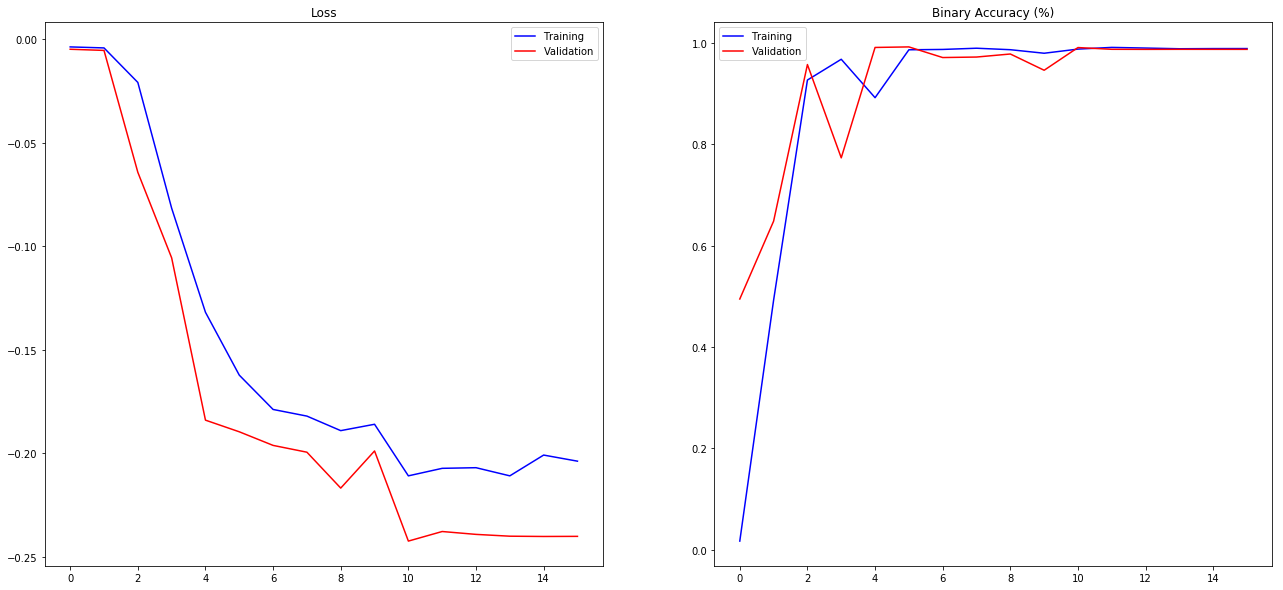

In [31]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

## Визуализация данных

In [32]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

(10, 8)


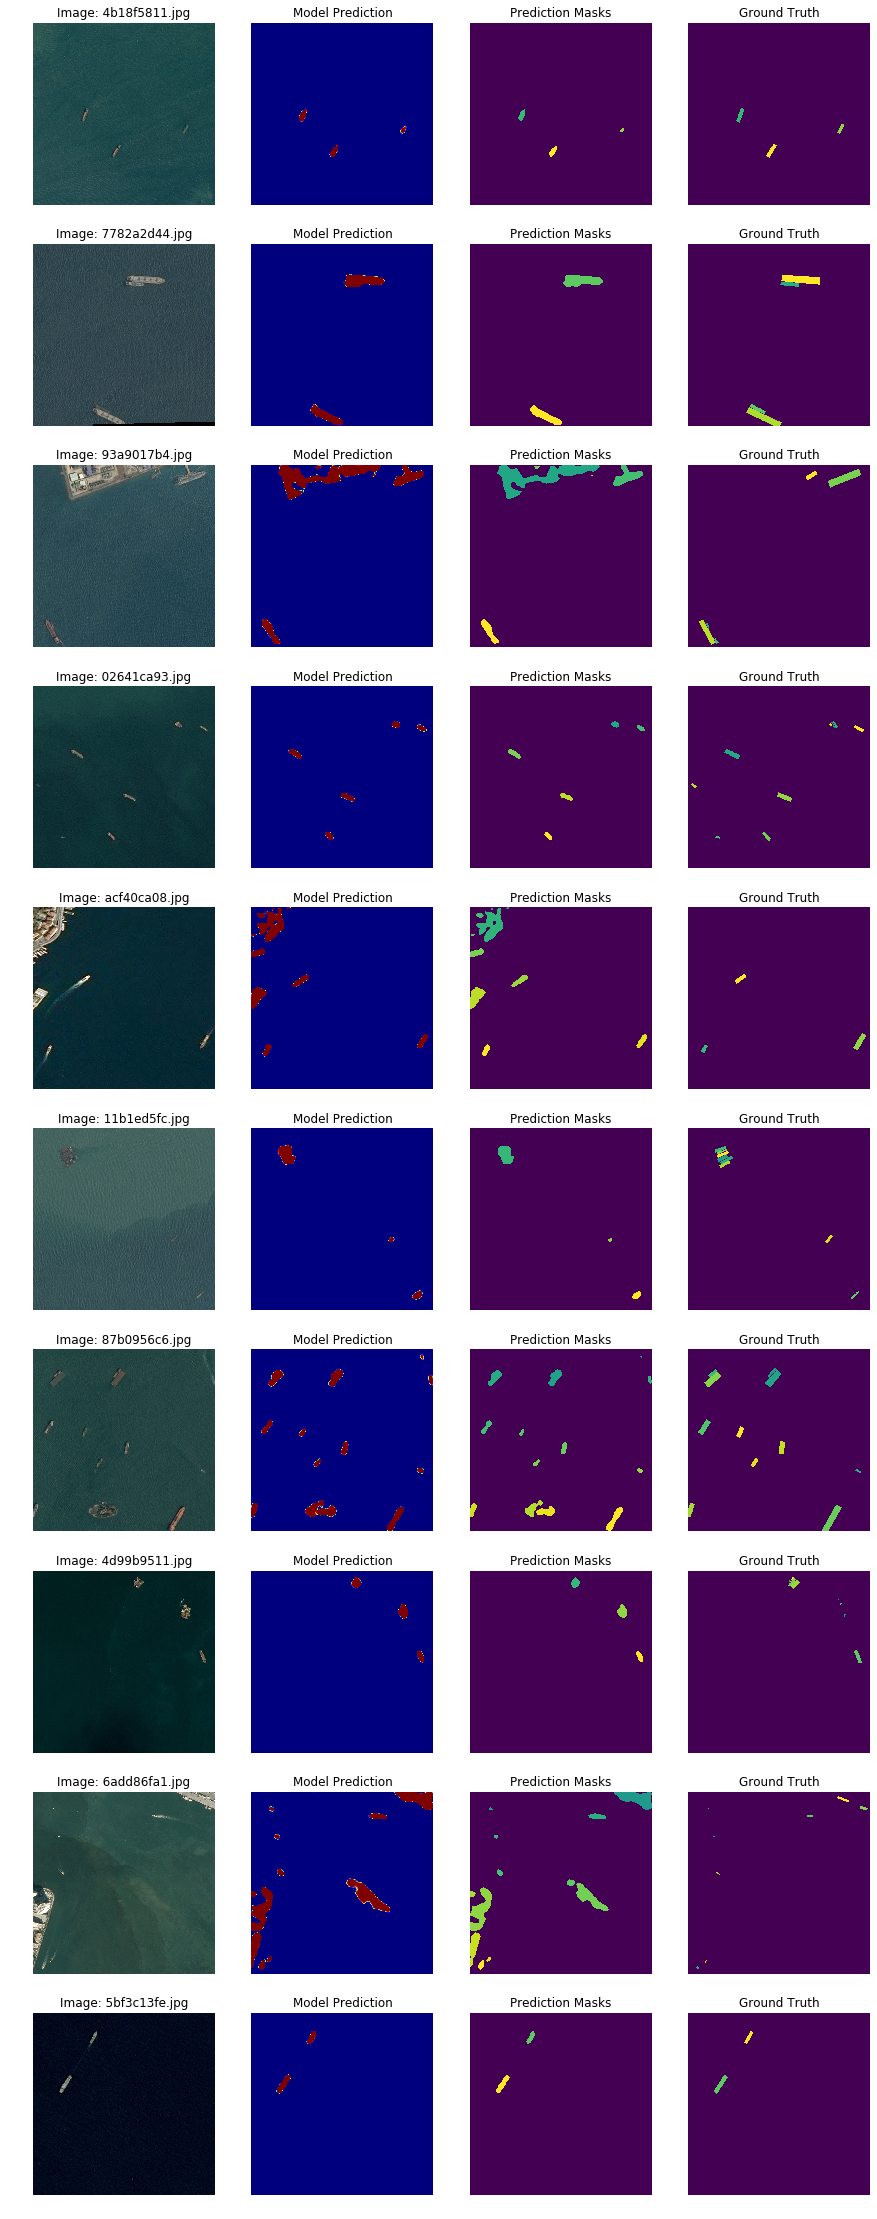

In [33]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(10))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

print(samples.shape)

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
fig.show()
    
#fig.savefig('validation.png')

In [34]:
samples.head(7)

Unnamed: 0        ImageId  \
ships                                   
1     1134        9581  4b18f5811.jpg   
      1778       15156  7782a2d44.jpg   
      2150       18428  93a9017b4.jpg   
      27           243  02641ca93.jpg   
      2527       21577  acf40ca08.jpg   
      290         2223  11b1ed5fc.jpg   
      1999       16960  87b0956c6.jpg   

                                                EncodedPixels  ships  \
ships                                                                  
1     1134  156318 2 157083 5 157849 8 158614 11 159379 14...      1   
      1778  189639 2 190405 4 191171 7 191937 9 192703 12 ...      1   
      2150  59038 2 59806 5 60573 9 61341 12 62108 15 6287...      1   
      27    288465 2 289230 5 289996 8 290761 11 291526 15...      1   
      2527  150838 1 151605 4 152373 5 153140 8 153907 11 ...      1   
      290   86108 2 86876 5 87643 9 88411 12 89179 14 8994...      1   
      1999  434685 1 435451 3 436217 6 436983 8 437749 11 ...      1   

            count_ships  has_ship has_ship_vec  file_size_kb  
ships                                                         
1     1134            3       1.0        [1.0]    120.722656  
      1778            4       1.0        [1.0]    145.043945  
      2150            5       1.0        [1.0]    139.726562  
      27              9       1.0        [1.0]    107.770508  
      2527            3       1.0        [1.0]     86.526367  
      290             8       1.0        [1.0]    123.458984  
      1999           11       1.0        [1.0]    123.971680

## Запись решения

In [43]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

5762 test images found


In [46]:
%%time

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
i = 0
for c_img_name in (test_paths): ## only a subset as it takes too long to run
    if i % 1000 == 0:
        print('Processing {} thousand images'.format(i // 1000))
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)
    i += 1

Processing 1 thousand images
Processing 1 thousand images
Processing 1 thousand images
Processing 1 thousand images
Processing 1 thousand images
Processing 1 thousand images


In [52]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.to_csv('F:\\Downloads\\all\\Submission_simple_ships_unet_v2.csv', index=False)
sub.head()
sub.shape

(21836, 2)

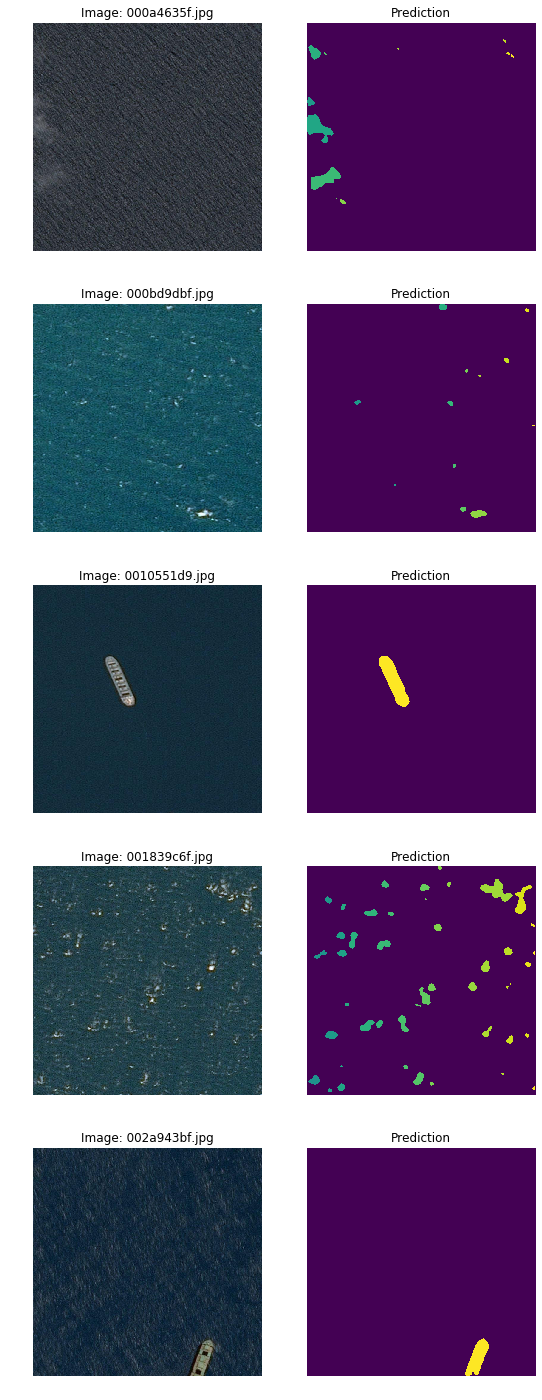

In [48]:
## let's see what we got
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = imread(os.path.join(test_image_dir, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')